In [16]:
import astropy
from astropy.io import fits
from astropy import units as u

import numpy as np
import matplotlib.pyplot as plt

import sherpa
import sherpa.astro.ui as ui
from sherpa.models.basic import Gauss1D, PowLaw1D
from sherpa.models import PowLaw1D
from sherpa.data import Data1D
from sherpa.plot import DataPlot, ModelPlot, FitPlot
from sherpa.stats import LeastSq
from sherpa.optmethods import LevMar, NelderMead
from sherpa.fit import Fit

Filename: assets/binary_table.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     15   200R x 3C   [D, D, D]   


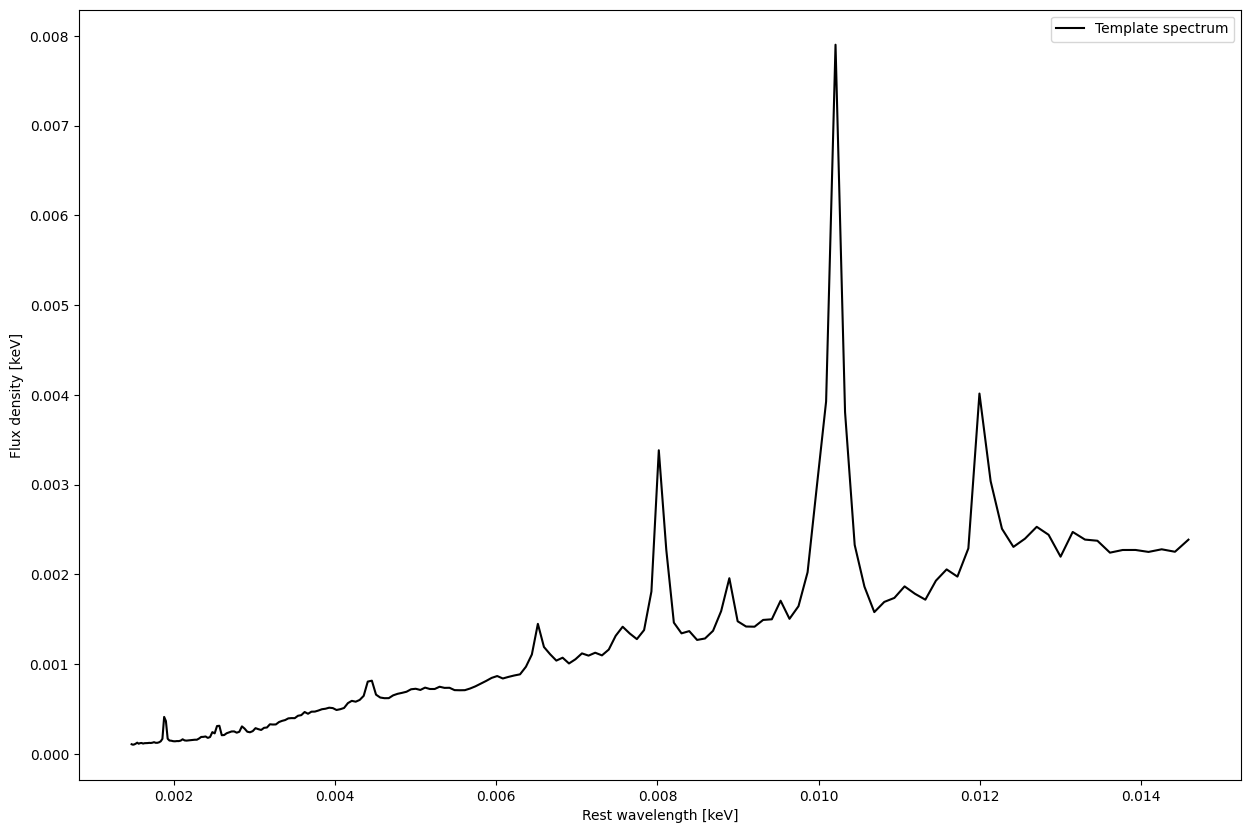

In [17]:
#FITS file with spectral data
hdul = astropy.io.fits.open("assets/binary_table.fits")
hdul.info()

#save the FITS file as an array
binary_table = hdul[1]
data = binary_table.data

wave_arr = np.array(data['Wavelength']) #Array containing wave data in angstroms
keV_arr = np.array(data['Energy: keV']) #Array containing wave data in keV
flambda_arr = np.array(data['Flambda']) #Array containing flux density

#plot the template spectra in keV 
fig1 = plt.figure(figsize=(15,10))
plt.xlabel('Rest wavelength [keV]')
plt.ylabel('Flux density [keV]')
plt.plot(keV_arr, flambda_arr, color='k', ls='-', label='Template spectrum')
plt.legend(loc='best')
plt.show()

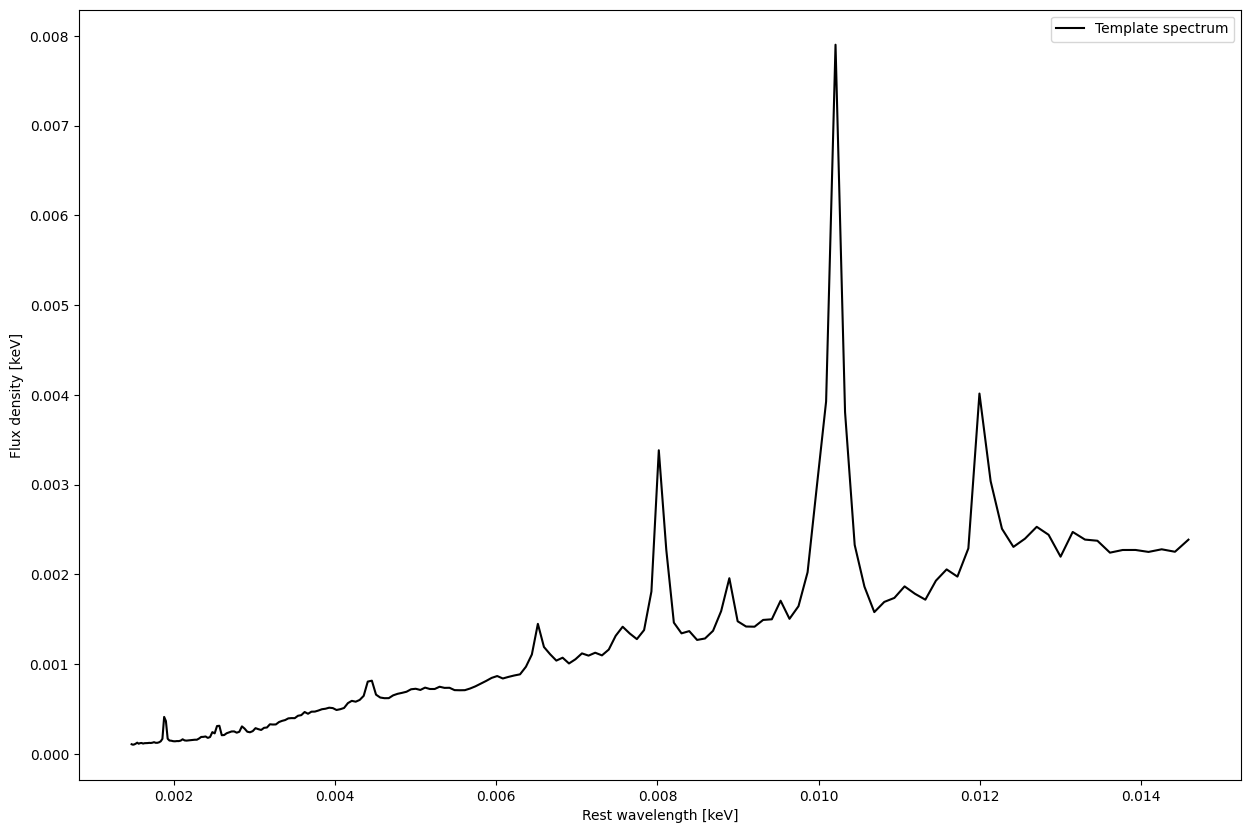

Spectrum Data Object:


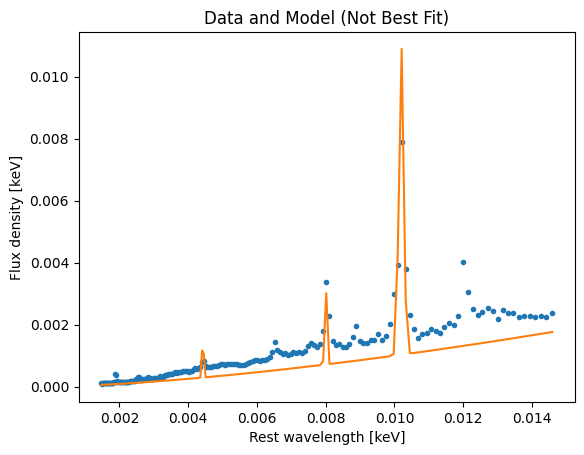

Model Object: 
data      = Data and Model (Not Best Fit)
model     = (((gauss1d + gauss1d) + gauss1d) + powlaw1d)
stat      = LeastSq
method    = LevMar
estmethod = Covariance
Model Result:  True


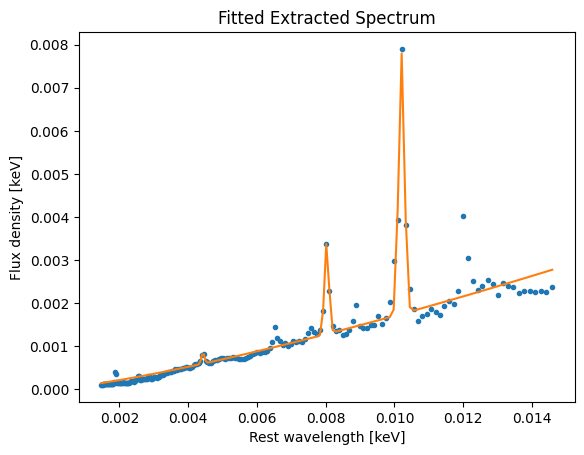

In [20]:
#create AGN model

#create the power law continuum model
#set initial photon index of power law to 2
powerlaw = PowLaw1D()
powerlaw.gamma = -1.5

#note redshift has not been accounted for just yet
#rest wavelengths of gaussian line models (nm)
#need to convert to keV as ARF and RMF are in keV
lyman_wave = 1215.67    
lyman_keV = (lyman_wave * u.angstrom).to(u.keV, equivalencies=u.spectral())

mg_wave = 2798.75
mg_keV = (mg_wave * u.angstrom).to(u.keV, equivalencies=u.spectral())

c_wave = 1549.06
c_keV = (c_wave * u.angstrom).to(u.keV, equivalencies=u.spectral())
 
#create the Gaussian line models
#relative parameters for emission lines are taken from Vanden Berk paper
#paper link: https://ui.adsabs.harvard.edu/abs/2001AJ....122..549V/abstract 

#lyman alpha emission line taken at rest wavelength
lyman_alpha = Gauss1D()
lyman_alpha.pos = lyman_keV.value   #Lyman alpha position (keV)
lyman_alpha.ampl = 100/10000        #Lyman alpha amplitude (photon flux)
#obtain lyman alpha fwhm in keV 
lyman_x1 = lyman_wave - (19.46/2)
lyman_x2 = lyman_wave + (19.46/2)
lyman_x1_keV = ((lyman_x1 * u.angstrom).to(u.keV, equivalencies=u.spectral())).value
lyman_x2_keV = ((lyman_x2 * u.angstrom).to(u.keV, equivalencies=u.spectral())).value
lyman_fwhm = (lyman_x1_keV - lyman_x2_keV)
lyman_alpha.fwhm = lyman_fwhm       #Lyman alpha fwhm (keV)

#Mg[II] emission line taken at rest wavelength
mg_ii = Gauss1D()
mg_ii.pos = mg_keV.value            #Magnesium II position (keV)
mg_ii.ampl = 14.725/10000           #Magnesium II amplitude (photon flux)
#obtain Mg[II] fwhm in keV 
mg_x1 = mg_wave - (34.95/2)
mg_x2 = mg_wave + (34.95/2)
mg_x1_keV = ((mg_x1 * u.angstrom).to(u.keV, equivalencies=u.spectral())).value
mg_x2_keV = ((mg_x2 * u.angstrom).to(u.keV, equivalencies=u.spectral())).value
mg_fwhm = (mg_x1_keV - mg_x2_keV)
mg_ii.fwhm = mg_fwhm               #Magnesium II fwhm (keV)

#C[IV] emission line taken at rest wavelength
c_iv = Gauss1D()
c_iv.pos = c_keV.value             #Carbon IV position (keV)
c_iv.ampl = 25.291/10000           #Carbon IV amplitude (photon flux)
#obtain C[IV] fwhm in keV 
c_x1 = c_wave - (14.33/2)
c_x2 = c_wave + (14.33/2)
c_x1_keV = ((c_x1 * u.angstrom).to(u.keV, equivalencies=u.spectral())).value
c_x2_keV = ((c_x2 * u.angstrom).to(u.keV, equivalencies=u.spectral())).value
c_fwhm = (c_x1_keV - c_x2_keV)
c_iv.fwhm = c_fwhm                 #Carbon IV fwhm (keV)


#define the model 
#final model contains all emission lines present in AGN source 
#emission lines are added to the powerlaw
model = lyman_alpha + mg_ii + c_iv + powerlaw

#load template spectrum
template_spectrum_path = "assets/shang_etal_2011_figure6_flambdaunits.dat"


#plot the data - template spectrum 
fig1 = plt.figure(figsize=(15,10))
plt.xlabel('Rest wavelength [keV]')
plt.ylabel('Flux density [keV]')
plt.plot(keV_arr, flambda_arr, color='k', ls='-', label='Template spectrum')
plt.legend(loc='best')
plt.show()

#create a data object that pertains to the above template spectrum
model_data = Data1D('Data and Model (Not Best Fit)', keV_arr, flambda_arr)
print("Spectrum Data Object:")

#create data plot
dplot = DataPlot()
dplot.prepare(model_data)

#create model plot
mplot = ModelPlot()
mplot.prepare(model_data, model)

#plot model and data on same graph
dplot.plot()
mplot.overplot()
plt.xlabel('Rest wavelength [keV]')
plt.ylabel('Flux density [keV]')
plt.title('Data and Model (Not Best Fit)')
plt.show()

#least-square statistic is used
stat = LeastSq()
#optimiser is the part that determines how to minimise the statistic value
#Levenberg-Marquardt (LevMar) is used
opt = LevMar()

#fit the data using the chosen statistic and optimizer method
#best fit of the data set is determined when the least square stat is minimized 
modelfit = Fit(model_data, model, stat=stat, method=opt)
print("Model Object: ")
modelres = modelfit.fit()

#plot the fit 
fplot = FitPlot()
mplot.prepare(model_data, model)
fplot.prepare(dplot, mplot)
fplot.plot()
plt.xlabel('Rest wavelength [keV]')
plt.ylabel('Flux density [keV]')
plt.title("Fitted Extracted Spectrum")
plt.show()

In [1]:
#empty lists for parameters of each emission line

m_amp= [] #list of the Mg emission line amplitudes
c_amp = [] #list of the Calcium emission line amplitudes
l_amp = [] #list of the Lyman-alpha emission line amplitudes

m_fwhm = [] #list of the Mg emission line full width max
c_fwhm = [] #list of the Calcium emission line full width max
l_fwhm = [] #list of the Lyman-alpha emission line full width max

m_pos = [] #list of the Mg emission line positions
c_pos = [] #list of the Calcium emission line positions
l_pos = [] #list of the Lyman-alpha emission line positions

p_gamma = [] #list of powerlaw photon index for each model


In [3]:
#taking input on parameters for each spectra model

#input number of spectra created
n_spectra = int(input("How many spectra do you want to generate: "))

#ask for parameters of each emission line for each spectra
#all parameters are in units of energy, keV
for x in range(n_spectra):
    print(f"For spectra {x}: ")

    #TO-DO: add if else statements

    # Magnesium II 
    amp = float(input("Enter the amplitude of the Mg II emission line: ")) #Mg amp
    m_amp.append(amp)
    
    full_width = float(input("Enter the FWHM of the Mg II emission line: ")) #Mg fwhm
    m_fwhm.append(full_width)
    
    pos = float(input("Enter the position of the Mg II emission line: ")) #Mg pos
    m_pos.append(pos)
    
    #Calcium IV
    amp = float(input("Enter the amplitude of the C IV emission line: ")) #C IV amp
    c_amp.append(amp)
    
    full_width = float(input("Enter the FWHM of the C IV emission line: ")) #C IV fwhm
    c_fwhm.append(full_width)
    
    pos = float(input("Enter the position of the C IV emission line: ")) #C IV pos
    c_pos.append(pos)
    
    #Lyman-alpha 
    amp = float(input("Enter the amplitude of the Lyman-alpha emission line: ")) #Ly-a amp
    l_amp.append(amp)
    
    full_width = float(input("Enter the FWHM of the Lyman-alpha emission line: ")) #Ly-a fwhm
    l_fwhm.append(full_width)
    
    pos = float(input("Enter the position of the Lyman-alpha emission line: ")) #Ly-a pos
    l_pos.append(pos)
    
    powlaw = float(input("Enter the powerlaw photon index: ")) #photon index of the powerlaw
    p_gamma.append(powlaw)
        

For spectra 0: 


Model: 0.0015
[0.0015, 0.0015]


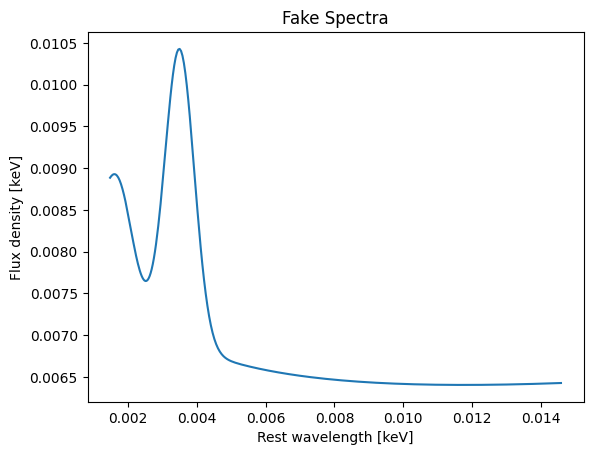

In [60]:
#loop for creating and plotting each spectra model
#creates a new model with each iteration

for y in range(n_spectra):
    print("Spectra: " + str(m_amp[y]))
    
    #assigning parameters for each spectra from lists

    #magnesium parameters
    mg_ii.ampl = m_amp[y] 
    mg_ii.fwhm = m_fwhm[y]
    mg_ii.pos = m_pos[y]
    
    #calcium parameters
    c_iv.ampl = c_amp[y] 
    c_iv.fwhm = c_fwhm[y] 
    c_iv.pos = c_pos [y]
    
    #lyman_alpha parameters
    lyman_alpha.ampl = l_amp[y]
    lyman_alpha.fwhm = l_fwhm[y] 
    lyman_alpha.pos = l_pos[y]
    
    #create model to plot
    AGN_model = mg_ii  + c_iv + lyman_alpha + powerlaw

    #create model plot
    mplot = ModelPlot()
    mplot.prepare(model_data, AGN_model)

    mplot.overplot()
    plt.xlabel('Rest wavelength [keV]')
    plt.ylabel('Flux density [keV]')
    plt.title('Fake Spectra')
    plt.show()

Model: 0
Model Result:  True


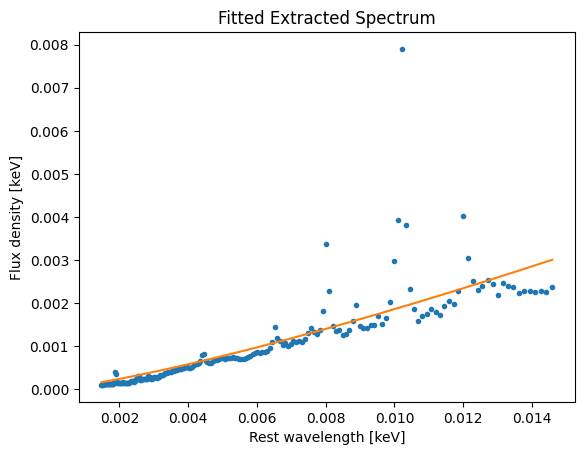

In [61]:
for y in range(n_spectra):
    print("Model: " + str(y))

    ui.set_model(AGN_model)


    #fitting
    modelfit = Fit(model_data, AGN_model, stat=stat, method=opt)    
    modelres = modelfit.fit()
    print("Model Result: ", modelres.succeeded)

    #plot the fit 
    fplot = FitPlot()
    mplot.prepare(model_data, AGN_model)
    fplot.prepare(dplot, mplot)
    fplot.plot()
    plt.xlabel('Rest wavelength [keV]')
    plt.ylabel('Flux density [keV]')
    plt.title("Fitted Extracted Spectrum")
    plt.show()